In [103]:
from preparing_script import agrofiz_plot, SVD_vis, Kvu, ob_ves_plot
import pandas as pd 
import numpy as np 
import scipy 
from scipy.stats import f_oneway as ANOVA
from itertools import cycle

import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Задачи 
- Бар плоты по фракциям сухого и мокрого просеивания 
- Лепестковые диаграмы  (https://python-graph-gallery.com/radar-chart/)
- Статистистика по всем объектам (с графикой и опсательными статистиками)

## Сухое просеивание 

In [77]:
suhoe = pd.read_csv('data/сухое просеивание все объекты.csv', index_col= 0)
size_cats = ['>10','10-7','7-5', '5-3', '3-2', '2-1', '1-0.5', '0.5-0.25', '<0.25']
suhoe['Размер агрегатов, мм'] = pd.CategoricalIndex(suhoe['Размер агрегатов, мм'], ordered=True, categories=size_cats)

In [78]:
test_df = suhoe[
    (suhoe["region"] == 'урожайное') & 
    (suhoe["Год"] == 2022) &
    suhoe['GPS №'].isin(['XX', 'XVIII'])
    ]

In [79]:
test_df.columns

Index(['Размер агрегатов, мм', 'Вес, г', 'Поврторность', 'GPS №', 'Год',
       'Тип обработки', 'region', 'Вес монолита, г',
       'Содержание агрегатов, %'],
      dtype='object')

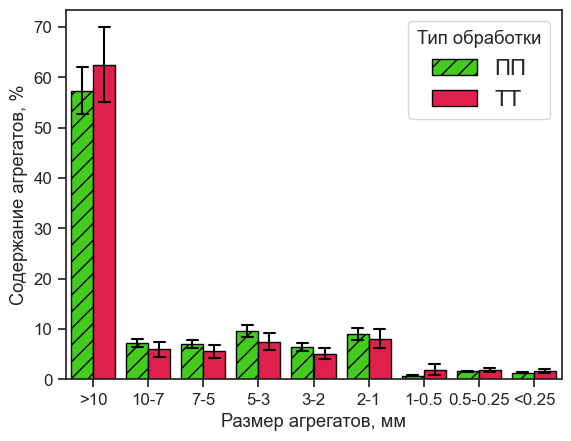

In [80]:
sns.set(font_scale=1.1)
sns.set_style("ticks")

ax = sns.barplot(test_df,
            y="Содержание агрегатов, %",
            x="Размер агрегатов, мм",
            hue="Тип обработки",
            palette = "prism",
            edgecolor = "black",
            errcolor = "black",
            errorbar = 'se',
            capsize = 0.2,
            errwidth = 1.5)

for i, patch in enumerate(ax.patches):
        if i < len(ax.patches)/2:
            patch.set_hatch("//")
ax.legend(loc='best', fontsize = 16, title='Тип обработки')


In [112]:
#придется усреднять монолиты для того чтобы упростить работу
rebuild = test_df[["Тип обработки","GPS №",'Размер агрегатов, мм',"Вес, г", "Вес монолита, г"]].groupby(["Тип обработки",'Размер агрегатов, мм']).agg(['mean']).round(2).reset_index()
rebuild = rebuild.droplevel(1, axis = 1)
rebuild['соотношение'] = (rebuild['Вес, г'] / rebuild['Вес монолита, г'] * 100).round(2)

### украденный из интернета код)

In [139]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

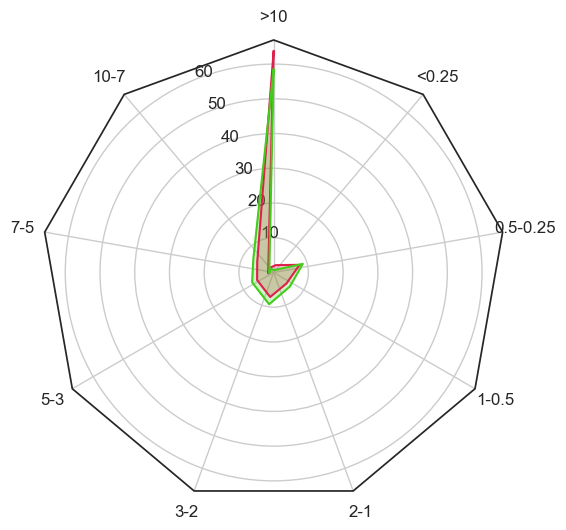

In [150]:
PP = rebuild[rebuild['Тип обработки']  == 'ПП']["соотношение"].to_list()
TT = rebuild[rebuild['Тип обработки']  != 'ПП']["соотношение"].to_list()


size_cats = ['>10','10-7','7-5', '5-3', '3-2', '2-1', '1-0.5', '0.5-0.25', '<0.25']


data = [size_cats, ('тип обработки', [PP, TT])]

theta = radar_factory(len(size_cats), frame='polygon')



fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

line = ax.plot(size_cats, TT, color = '#df204c')
ax.fill(size_cats, TT, color = '#df204c' ,alpha=0.25)

line = ax.plot(size_cats, PP, color = '#43cc1d')
ax.fill(size_cats, PP, color = '#43cc1d' ,alpha=0.25)



ax.set_varlabels(size_cats)

### Коэф структурности

F_onewayResult(statistic=0.09256100972374928, pvalue=0.7657615565264019)

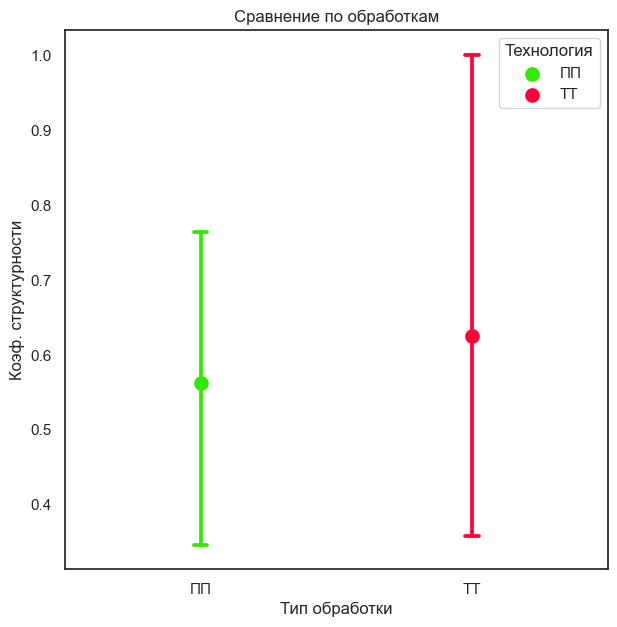

In [7]:
stats, aov, fig = agrofiz_plot(agrofiz, 'Коэф. структурности')
aov


In [6]:
stats

Коэф. структурности                    
                             mean       std variation
Тип обработки                                        
ПП                       0.754630  0.196471  0.232868
ТТ                       0.879442  0.547391  0.556718

### СВД воздушно сухие

F_onewayResult(statistic=0.557514244018155, pvalue=0.4685529177654608)

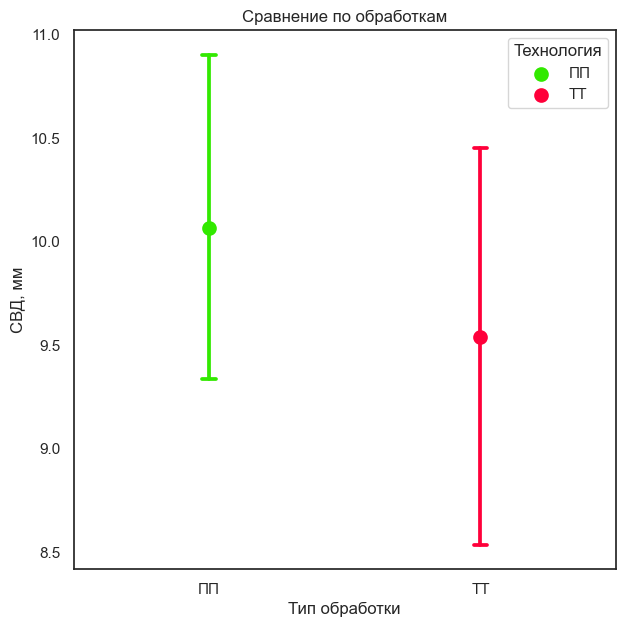

In [9]:
stats, aov, fig = agrofiz_plot(agrofiz, 'СВД, мм')
aov


In [10]:
stats

СВД, мм                    
                    mean       std variation
Тип обработки                               
ПП             10.067986  1.347680  0.126202
ТТ              9.540068  1.331543  0.127413

### СВД водоустойчивые 

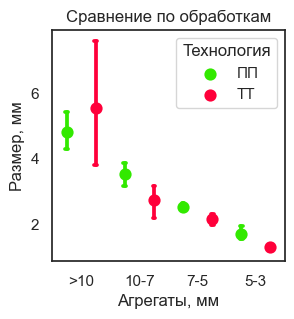

,агрегаты,P-val
0,"СВД водоустойчивые >10, мм",0.449237
1,"СВД водоустойчивые 10-7, мм",0.031635
2,"СВД водоустойчивые 7-5, мм",0.008729
3,"СВД водоустойчивые 5-3, мм",0.012583


In [11]:


stats, aov, fig = SVD_vis(agrofiz)
aov

In [12]:
stats

СВД водоустойчивые >10, мм                      \
                                    mean       std variation   
Тип обработки                                                  
ПП                              4.805931  0.932647  0.182963   
ТТ                              5.531060  2.587130  0.426992   

              СВД водоустойчивые 10-7, мм                      \
                                     mean       std variation   
Тип обработки                                                   
ПП                               3.521458  0.571366  0.152973   
ТТ                               2.735688  0.688999  0.229912   

              СВД водоустойчивые 7-5, мм                      \
                                    mean       std variation   
Тип обработки                                                  
ПП                              2.513961  0.221472  0.083059   
ТТ                              2.146469  0.233488  0.099300   

              СВД водоустойчивые 5-3, мм                      
                                    mean       std variation  
Тип обработки                                                 
ПП                              1.705928  0.328187  0.181378  
ТТ                              1.288273  0.150961  0.106971

# курск

In [13]:
agrofiz = pd.read_csv("data/агрофизика_курск.csv")


In [14]:
agrofiz

,Год,GPS №,Тип обработки,повторность,"Содержание 0.25–10 мм, %","Содержание >10, %","Содержание <0.25, %",Коэф. структурности,"СВД, мм","СВД водоустойчивые 10-7, мм","СВД водоустойчивые 5-3, мм","СВД водоустойчивые 7-5, мм","СВД водоустойчивые >10, мм"
0,2019,NaN,ПП,1,0.403684,0.588085,0.008230,0.676964,9.106996,1.333750,0.831250,1.120187,0.932563
1,2019,NaN,ПП,2,0.447378,0.526966,0.025655,0.809556,8.386025,2.011437,0.852812,1.185625,2.714813
2,2019,NaN,ПП,3,0.502054,0.491146,0.006800,1.008250,8.300786,3.207375,1.096563,1.506813,2.732187
3,2019,NaN,ПП,4,0.321712,0.669644,0.008644,0.474299,9.825944,2.183500,0.872625,1.336062,6.419937
4,2019,NaN,ПП,5,0.445702,0.548641,0.005658,0.804083,8.849472,1.772812,0.785625,1.132437,3.675625
5,2019,NaN,ТТ,1,0.311057,0.674146,0.014797,0.451499,9.826951,2.401937,1.014625,1.616687,4.966687
6,2019,NaN,ТТ,2,0.631161,0.352299,0.016540,1.711211,6.609721,1.598500,1.140187,1.242438,2.415000
7,2019,NaN,ТТ,3,0.257853,0.729993,0.012154,0.347443,10.358241,3.200937,0.880562,1.469875,8.581125
8,2019,NaN,ТТ,4,0.449453,0.544659,0.005887,0.816376,8.622014,2.743688,1.192750,1.754500,4.900813
9,2019,NaN,ТТ,5,0.517067,0.475889,0.007044,1.070681,7.898253,3.380250,1.060625,1.706187,5.236937


F_onewayResult(statistic=0.2302805368267326, pvalue=0.6441613429091824)

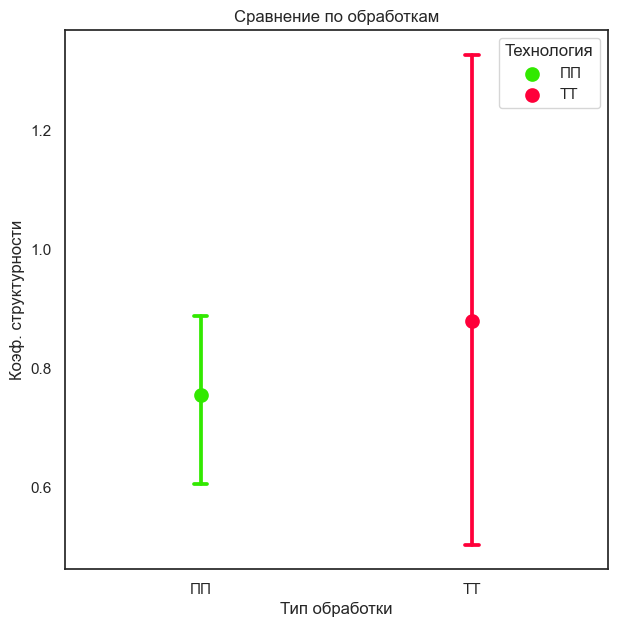

In [15]:
stats, aov, fig = agrofiz_plot(agrofiz, 'Коэф. структурности')
aov


In [16]:
stats


Коэф. структурности                    
                             mean       std variation
Тип обработки                                        
ПП                       0.754630  0.196471  0.232868
ТТ                       0.879442  0.547391  0.556718

СВД воздушно сухие


F_onewayResult(statistic=0.10092454302937615, pvalue=0.7588565913465707)

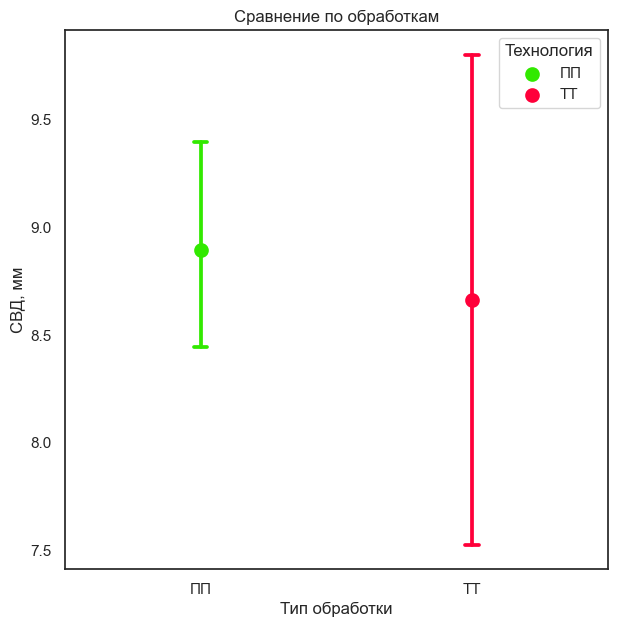

In [17]:
stats, aov, fig = agrofiz_plot(agrofiz, 'СВД, мм')
aov

In [18]:
stats


СВД, мм                    
                   mean       std variation
Тип обработки                              
ПП             8.893845  0.617618  0.062112
ТТ             8.663036  1.502589  0.155137

СВД водоустойчивые


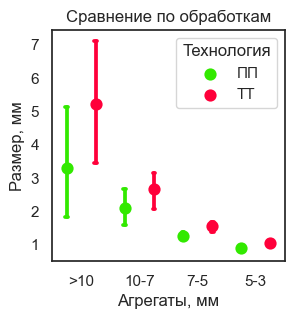

,агрегаты,P-val
0,"СВД водоустойчивые >10, мм",0.186344
1,"СВД водоустойчивые 10-7, мм",0.240456
2,"СВД водоустойчивые 7-5, мм",0.034019
3,"СВД водоустойчивые 5-3, мм",0.056940


In [19]:
stats, aov, fig = SVD_vis(agrofiz)
aov

In [20]:
stats


СВД водоустойчивые >10, мм                      \
                                    mean       std variation   
Тип обработки                                                  
ПП                              3.295025  2.009017  0.545343   
ТТ                              5.220113  2.198381  0.376676   

              СВД водоустойчивые 10-7, мм                      \
                                     mean       std variation   
Тип обработки                                                   
ПП                               2.101775  0.695570  0.296005   
ТТ                               2.665062  0.709159  0.238002   

              СВД водоустойчивые 7-5, мм                      \
                                    mean       std variation   
Тип обработки                                                  
ПП                              1.256225  0.164303  0.116983   
ТТ                              1.557938  0.206979  0.118829   

              СВД водоустойчивые 5-3, мм                      
                                    mean       std variation  
Тип обработки                                                 
ПП                              0.887775  0.121113  0.122021  
ТТ                              1.057750  0.120711  0.102072